In [1]:
from typing import Callable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr

import network
from network import Weight
from preprocess_data import Game, PowerPlay, Situation, Venue, read_networks

In [2]:
def regular_networks():
    return read_networks(Situation.REGULAR)


def power_play_networks():
    return read_networks(Situation.POWER_PLAY)


def penalty_kill_networks():
    return read_networks(Situation.PENALTY_KILL)

In [3]:
def fit(df: pd.DataFrame, covariates: List[str], target: str, family: str = "binomial"):
    X = df[covariates]
    X = sm.add_constant(X)
    y = df[target]
    match family:
        case "binomial":
            model = sm.Logit(y, X)
        case "poisson":
            model = sm.GLM(y, X, family=sm.families.Poisson())
        case "gaussian":
            model = sm.OLS(y, X)
        case _:
            raise ValueError(f"{family} regression not implemented")
    res = model.fit()
    print(res.summary())

# Match Outcome Prediction

In [4]:
def get_win_df(features: List[Callable] | Callable) -> pd.DataFrame:
    """
    Builds a dataframe of features for each game using the regular situations (no Power Play and Penalty Kill).

    Args:
        features (List[Callable] | Callable): features to be computed for each game

    Returns:
        pd.DataFrame: Dataframe with columns game_str, log_n_passes, win, and features
    """
    if callable(features):
        features = [features]
    df = pd.DataFrame(
        [
            {"game_str": G.name, "n_passes": G.n_passes, "log_n_passes": np.log(G.n_passes), "win": G.win}
            | {feature.__name__: feature(G) for feature in features}
            for G in regular_networks()
        ]
    )
    return df

We don't look at connectivity ($\gamma$) and number of strongly connected components ($\sigma$) because our networks are all regular. 

In [33]:
features = [
    network.assortativity,
    network.clustering,
    # network.degree_mean,
    # network.degree_std,
]
df = get_win_df(features)
df

,game_str,n_passes,log_n_passes,win,assortativity,clustering
0,2022-02-08 Canada at USA_reg_home,216.0,5.375278,0,0.120174,0.461392
1,2022-02-08 Canada at USA_reg_away,185.0,5.220356,1,-0.102773,0.474962
2,2022-02-08 ROC at Finland_reg_home,265.0,5.579730,1,0.041894,0.493256
3,2022-02-08 ROC at Finland_reg_away,200.0,5.298317,0,-0.120709,0.389216
4,2022-02-12 Switzerland at ROC_reg_home,266.0,5.583496,0,-0.026035,0.497432
5,2022-02-12 Switzerland at ROC_reg_away,212.0,5.356586,1,0.211820,0.476648
6,2022-02-14 Switzerland at Canada_reg_home,331.0,5.802118,1,0.028629,0.674079
7,2022-02-14 Switzerland at Canada_reg_away,147.0,4.990433,0,0.030374,0.296738
8,2022-02-14 USA at Finland_reg_home,239.0,5.476464,0,0.077702,0.432872
9,2022-02-14 USA at Finland_reg_away,220.0,5.393628,1,0.184663,0.563418


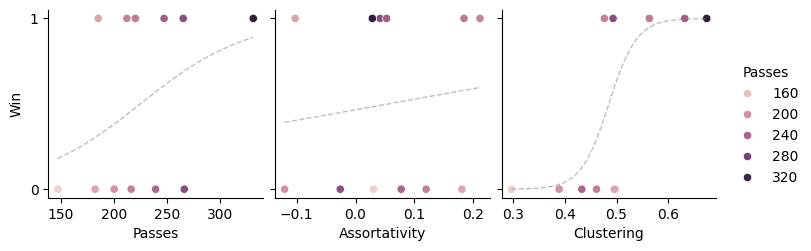

In [58]:
df = get_win_df(features)
xs = ["n_passes"] + [feature.__name__ for feature in features]
x_labels = {"n_passes": "Passes", "assortativity": "Assortativity", "clustering": "Clustering"}

grid = sns.pairplot(
    df,
    x_vars=xs,
    y_vars=["win"],
    hue="n_passes",
)
for x, ax in zip(xs, grid.axes[0]):
    sns.regplot(
        x=x,
        y="win",
        data=df,
        logistic=True,
        ci=None,
        ax=ax,
        scatter=False,
        color="grey",
        line_kws={"lw": 1, "ls": "--", "alpha": 0.5},
    )
    ax.set_xlabel(x_labels[x])
    ax.set_ylabel("Win")
    plt.yticks([0, 1])

grid.legend.set_title("Passes")
plt.savefig("report/images/hockey/winner_scatter.png", dpi=600, bbox_inches="tight")

In [35]:
df = get_win_df(features)
fit(df, ["n_passes"], "win", "binomial")

Optimization terminated successfully.
         Current function value: 0.615079
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                   12
Model:                          Logit   Df Residuals:                       10
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Dec 2023   Pseudo R-squ.:                  0.1126
Time:                        15:35:16   Log-Likelihood:                -7.3809
converged:                       True   LL-Null:                       -8.3178
Covariance Type:            nonrobust   LLR p-value:                    0.1711
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3906      3.664     -1.198      0.231     -11.571       2.790
n_passes       0.0195      0.

In [36]:
df = get_win_df(features)
fit(df, ["clustering"], "win", "binomial")

Optimization terminated successfully.
         Current function value: 0.394933
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                   12
Model:                          Logit   Df Residuals:                       10
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Dec 2023   Pseudo R-squ.:                  0.4302
Time:                        15:35:23   Log-Likelihood:                -4.7392
converged:                       True   LL-Null:                       -8.3178
Covariance Type:            nonrobust   LLR p-value:                  0.007467
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.9745     13.762     -1.306      0.192     -44.948       8.999
clustering    37.0475     28.

Conclusion: doesn't work (i.e. no significance). There are two possible explanations:
- We are using too little data
- The investigated features are not predictive

We have data from six games, giving twelve data points. Hence, it would not be surprising if that is not enough data.

# Goals Scored

In [8]:
def get_goals_df(features: List[Callable] | Callable) -> pd.DataFrame:
    """
    Builds a dataframe of features for each game using the regular situations (no Power Play and Penalty Kill).

    Args:
        features (List[Callable] | Callable): features to be computed for each game

    Returns:
        pd.DataFrame: Dataframe with columns game_str, log_n_passes, win, and features
    """
    if callable(features):
        features = [features]
    df = pd.DataFrame(
        [
            {
                "game_str": G.name,
                "n_passes": G.n_passes,
                "log_n_passes": np.log(G.n_passes),
                "win": G.win,
                "goals": G.home_score if G.venue == Venue.HOME else G.away_score,
            }
            | {feature.__name__: feature(G) for feature in features}
            for G in regular_networks()
        ]
    )
    return df

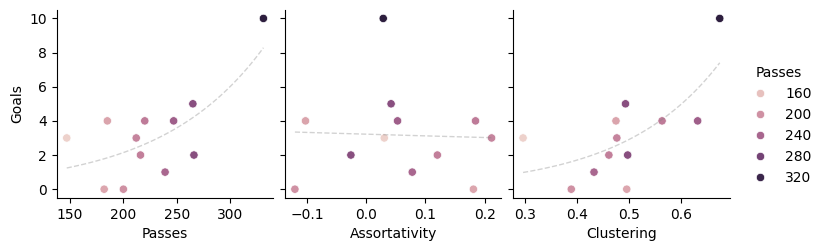

In [57]:
df = get_goals_df(features)
xs = ["n_passes"] + [feature.__name__ for feature in features]
x_labels = {"n_passes": "Passes", "assortativity": "Assortativity", "clustering": "Clustering"}

grid = sns.pairplot(
    df,
    x_vars=xs,
    y_vars=["goals"],
    hue="n_passes",
)
for x, ax in zip(xs, grid.axes[0]):
    lm = sm.GLM(df["goals"], sm.add_constant(df[x]), family=sm.families.Poisson()).fit()
    inputs = np.linspace(df[x].min(), df[x].max(), 100)
    sns.lineplot(
        x=inputs,
        y=lm.predict(sm.add_constant(inputs)),
        ax=ax,
        color="grey",
        **{"lw": 1, "ls": "--", "alpha": 0.35},
    )
    ax.legend().remove()
    ax.set_xlabel(x_labels[x])
    ax.set_ylabel("Goals")

grid.legend.set_title("Passes")
plt.savefig("report/images/hockey/goals_scatter.png", dpi=600, bbox_inches="tight")

In [25]:
fit(df, ["n_passes"], "goals", "poisson")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.567
Date:                Thu, 14 Dec 2023   Deviance:                       16.487
Time:                        15:24:29   Pearson chi2:                     13.2
No. Iterations:                     4   Pseudo R-squ. (CS):             0.5674
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3002      0.808     -1.608      0.1

In [27]:
controls = {
    network.assortativity: ["n_passes"],
    network.clustering: ["n_passes"],
}

In [28]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_goals_df(feature)
    df.dropna(inplace=True)
    fit(df, covariates=[feature_name] + controls[feature], target="goals", family="poisson")
    print("\n\n")

Feature: assortativity
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                   12
Model:                            GLM   Df Residuals:                        9
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.557
Date:                Thu, 14 Dec 2023   Deviance:                       16.468
Time:                        15:24:57   Pearson chi2:                     13.4
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5681
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.334

In [30]:
pearsonr(df["n_passes"], df["clustering"])

PearsonRResult(statistic=0.7537163877296461, pvalue=0.004637936010571199)

# Power Play Success Prediction (Goal or nah)

In [69]:
def game_and_venue(G) -> Tuple[Game, Venue]:
    return (G.game.game, G.venue)


def get_pp_df(features: List[Callable] | Callable) -> pd.DataFrame:
    """
    Builds a dataframe of features for each Power Play for regressing on the success of the Power Play (goal or not) or
    the number of shots.

    Args:
        features (List[Callable] | Callable): features to be computed for each PP

    Returns:
        pd.DataFrame: Dataframe with columns game_str, log_n_passes, target, normal_feature_1, ..., normal_feature_n, pp_feature_1, ..., pp_feature_n
    """
    if callable(features):
        features = [features]
    regular_feature_map = {game_and_venue(G): {feature: feature(G) for feature in features} for G in regular_networks()}
    df = pd.DataFrame(
        [
            {
                "game_str": G.name,
                "n_passes": G.n_passes,
                "log_n_passes": np.log(G.n_passes),
                "goal": G.goal,
                "n_shots": G.n_shots,
            }
            | {f"normal_{feature.__name__}": regular_feature_map[game_and_venue(G)][feature] for feature in features}
            | {f"pp_{feature.__name__}": feature(G) for feature in features}
            for G in power_play_networks()
        ]
    )
    for feature in features:
        df[f"{feature.__name__}_diff"] = df[f"normal_{feature.__name__}"] - df[f"pp_{feature.__name__}"]

    return df

In [70]:
get_pp_df(features).head(7)

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


,game_str,n_passes,log_n_passes,goal,n_shots,normal_assortativity,normal_clustering,pp_assortativity,pp_clustering,assortativity_diff,clustering_diff
0,2022-02-08 Canada at USA_2_pp_home,27.0,3.295837,0,4,0.120174,0.461392,-0.441123,0.221375,0.561296,0.240017
1,2022-02-08 Canada at USA_3_pp_home,21.0,3.044522,0,4,0.120174,0.461392,-0.098857,0.291941,0.219031,0.169451
2,2022-02-08 Canada at USA_4_pp_home,15.0,2.708050,1,3,0.120174,0.461392,-0.828079,0.220036,0.948252,0.241356
3,2022-02-08 Canada at USA_5_pp_home,11.0,2.397895,0,2,0.120174,0.461392,0.683130,0.111614,-0.562957,0.349778
4,2022-02-08 Canada at USA_6_pp_home,34.0,3.526361,0,6,0.120174,0.461392,-0.282587,0.349990,0.402761,0.111402
5,2022-02-08 Canada at USA_1_pp_away,12.0,2.484907,1,1,-0.102773,0.474962,-0.250000,0.567420,0.147227,-0.092458
6,2022-02-08 ROC at Finland_4_pp_home,10.0,2.302585,1,2,0.041894,0.493256,0.213201,0.000000,-0.171307,0.493256


/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


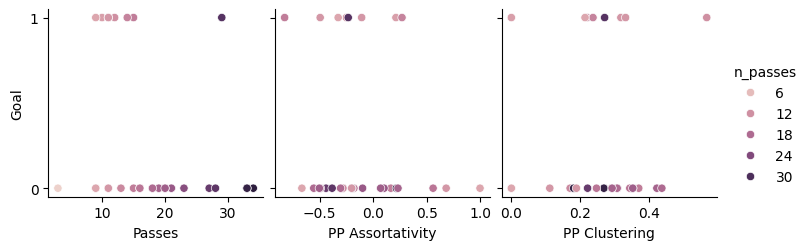

In [56]:
df = get_pp_df(features)
grid = sns.pairplot(
    df, hue="n_passes", x_vars=["n_passes"] + [f"pp_{feature.__name__}" for feature in features], y_vars=["goal"]
)
grid.axes[0][0].set_xlabel("Passes")
grid.axes[0][0].set_ylabel("Goal")
grid.axes[0][1].set_xlabel("PP Assortativity")
grid.axes[0][2].set_xlabel("PP Clustering")

plt.yticks([0, 1])
plt.savefig("report/images/hockey/pp_goal_scatter.png", dpi=600, bbox_inches="tight")

In [ ]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"normal_{feature_name}", f"pp_{feature_name}"] + controls[feature]
    fit(df, covariates=covariates, target="goal", family="binomial")
    print("\n\n")

Also doesn't work.

# Predicting Number of Shots

Let's first see if `n_passes` predicts `n_shots`.

In [45]:
df = get_pp_df(features)
fit(df, covariates=["n_passes"], target="n_shots", family="poisson")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   31
Model:                            GLM   Df Residuals:                       29
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.081
Date:                Thu, 14 Dec 2023   Deviance:                       35.234
Time:                        15:39:34   Pearson chi2:                     36.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4820
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.283      0.035      0.9

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


It does. The number of passes is a significant predictor of the number of shots (p<0.0005). The coefficient is 0.0563, which means that all else equal, for every additional pass, we expect an increase in the number of shots by a factor of $e^{0.0563}\approx 0.057$ (remember that we use Poisson regression). This means for every ~18 passes a team will have an extra shot.

Let's see if the other network features are also predictive of the number of shots.

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


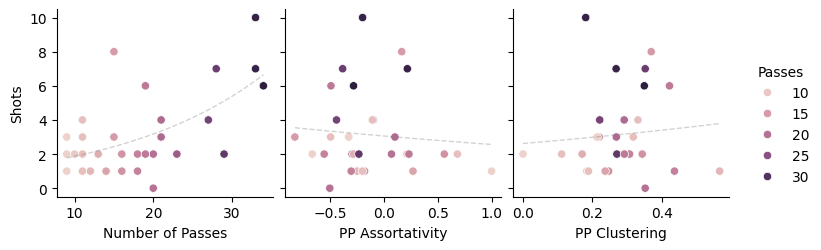

In [55]:
df = get_pp_df(features).dropna()
xs = ["n_passes"] + [f"pp_{feature.__name__}" for feature in features]
x_labels = {"n_passes": "Passes", "pp_assortativity": "PP Assortativity", "pp_clustering": "PP Clustering"}

grid = sns.pairplot(
    df,
    x_vars=xs,
    y_vars=["n_shots"],
    hue="n_passes",
)
for x, ax in zip(xs, grid.axes[0]):
    lm = sm.GLM(df["n_shots"], sm.add_constant(df[x]), family=sm.families.Poisson()).fit()
    inputs = np.linspace(df[x].min(), df[x].max(), 100)
    sns.lineplot(
        x=inputs,
        y=lm.predict(sm.add_constant(inputs)),
        ax=ax,
        color="grey",
        **{"lw": 1, "ls": "--", "alpha": 0.35},
    )
    ax.legend().remove()
    ax.set_xlabel(x_labels[x])
    ax.set_ylabel("Shots")
    # plt.yticks([0, 1])

grid.legend.set_title("Passes")
plt.savefig("report/images/hockey/pp_shots_scatter.png", dpi=600, bbox_inches="tight")

In [60]:
df = get_pp_df(features)
fit(df, covariates=["n_passes"], target="n_shots", family="poisson")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   31
Model:                            GLM   Df Residuals:                       29
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.081
Date:                Thu, 14 Dec 2023   Deviance:                       35.234
Time:                        16:02:01   Pearson chi2:                     36.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4820
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.283      0.035      0.9

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [61]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"pp_{feature_name}"] + controls[feature]
    fit(df, covariates=covariates, target="n_shots", family="poisson")
    print("\n\n")

Feature: assortativity
                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   30
Model:                            GLM   Df Residuals:                       27
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.830
Date:                Thu, 14 Dec 2023   Deviance:                       32.733
Time:                        16:03:03   Pearson chi2:                     34.1
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4274
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


`degree_mean` is a significant predictor of `n_shots`. This is not surprising given the above as `degree_mean` is highly correlated with `n_passes`.

On the other hand, `assortativity` and `clustering` are also not predictive in this task.

We can also include the features from regular play (not power play) and see if the features become more predictive by being able to look at the contrast between normal play and power play.

In [71]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"{feature_name}_diff"] + controls[feature]
    fit(df, covariates=covariates, target="n_shots", family="poisson")
    print("\n\n")

Feature: assortativity
                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   30
Model:                            GLM   Df Residuals:                       27
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.817
Date:                Thu, 14 Dec 2023   Deviance:                       32.707
Time:                        16:17:32   Pearson chi2:                     33.9
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4279
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const        

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
